<a href="https://colab.research.google.com/github/shekhar-hazari/CML-Assignment-2/blob/main/Luke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
In this task a cancer cell detection system will be created.

Luke Mason - s3630120 \
Shekhar Hazari - s3831855 asdasdasdasd

#### Import packages

In [4]:
import tensorflow
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### Initialise helper functions¶

In [5]:
def holdout_validation(train_size, X, Y):
    
    # Get the difference between train and test size, together both make 100% of the raw data set.
    test_size = 1 - train_size
    
    # Split into train and test for normal and target fields set, left overs are for validation and test.
    with pd.option_context('mode.chained_assignment', None):
        train_X, X_test_, train_Y, Y_test_ = train_test_split(X, Y, test_size=test_size, shuffle=True,random_state=0)

    # Split the test data into validation test and test.
    # Do for target field and normal fields.
    with pd.option_context('mode.chained_assignment', None):
         val_X, test_X, val_Y, test_Y = train_test_split(X_test_, Y_test_, test_size=0.5, shuffle=True, random_state=29)
    return train_X, val_X, test_X, train_Y, val_Y, test_Y

def hist_plot(title, columns, colours, nrows, ncols, index_pos, left=0.125, top=0.9, bottom=0.1, right=0.9, wspace=0.3, hspace=0.7):
    """
    Plots a histogram.
    :param title:     The title of the histogram.
    :param columns:   The data columns to plot on the histogram.
    :param colours:   The colours for each data column on the histogram.
    :param nrows:     The number of rows in the presentation table.
    :param ncols:     The number of columns in the presentation table.
    :param index_pos: The index of the histogram on the
    :param left:      How far to move away from left.
    :param top:       How far to move away from top.
    :param bottom:    How far to extend towards bottom.
    :param right:     How far to extend boundary towards right.
    :param wspace:    Height ratio spacing between plots.
    :param hspace:    Width ratio spacing between plots.
    :return:
    """
    plt.subplot(nrows,ncols,index_pos)
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
    for index_pos, column in enumerate(columns):
        plt.hist(column, alpha=0.3, color=colours[index_pos % len(colours)], density=True)
    plt.title(title)
    plt.xticks(rotation='vertical')

def train_val_test_split_by_column(dataframe, column, train_size = 0.666, val_size = 0.5):
  splitting_IDs = dataframe[column].unique()
  train_IDs, test_IDs = train_test_split(splitting_IDs, train_size = train_size)
  val_IDs, test_IDs = train_test_split(test_IDs, train_size = val_size)

  train_IDs = pd.DataFrame(train_IDs)
  train_IDs.rename(columns = {0:column}, inplace = True)
  train_IDs['split'] = 'train'

  val_IDs = pd.DataFrame(val_IDs)
  val_IDs.rename(columns = {0:column}, inplace = True)
  val_IDs['split'] = 'validation'

  test_IDs = pd.DataFrame(test_IDs)
  test_IDs.rename(columns = {0:column}, inplace = True)
  test_IDs['split'] = 'test'

  splits = pd.concat([train_IDs, val_IDs, test_IDs], ignore_index=True)

  dataframe = pd.merge(dataframe, splits, on = column)

  train_set = dataframe[dataframe['split'] == 'train']
  train_set = train_set.drop(['split'], axis = 1)

  validation_set = dataframe[dataframe['split'] == 'validation']
  validation_set = validation_set.drop(['split'], axis = 1)

  test_set = dataframe[dataframe['split'] == 'test']
  test_set = test_set.drop(['split'], axis = 1)

  return train_set, validation_set, test_set

#### Unzip zipped data

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
# Change according to your directory structure
!cp /content/drive/'My Drive'/CML-Assignment-2/Image_classification_data.zip .
!unzip -q -o Image_classification_data.zip
!rm Image_classification_data.zip
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


#### Load the main dataset
This data contains both the cell type and isCancerous labels.

In [8]:
main_data = pd.read_csv('data_labels_mainData.csv', delimiter=',')

#### Load the extra dataset
This dataset does not contain the cellType labels.

In [9]:
extra_data = pd.read_csv('./data_labels_extraData.csv', delimiter=',')

### 1 - Exploratory Data Analysis
The data is assumed to be made of entirely by newborn babies according to the assignment forums.\

#### 1.1 - Exploring the distribution of the data
In this section the data's distribution of values are examined. Observations and folowwing conclusions are made to be used for justifying the decisions made in the rest of the report.

##### 1.1.1 Exploring unique values and data types
Here the fields display the unique values there are and their frequency.

#### Previewing the main data

In [10]:
main_data.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [11]:
main_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [12]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


#### Previewing the extra data

In [13]:
extra_data.describe()

,InstanceID,patientID,isCancerous
count,10384.000000,10384.00000,10384.000000
mean,12087.866333,80.38203,0.287943
std,6173.866838,9.40388,0.452826
min,1631.000000,61.00000,0.000000
25%,6655.750000,71.00000,0.000000
50%,12377.500000,81.00000,0.000000
75%,16374.250000,88.00000,1.000000
max,22235.000000,99.00000,1.000000


In [14]:
extra_data.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [15]:
extra_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  int64 
 1   patientID    10384 non-null  int64 
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 324.6+ KB


### Transforming the data
Set all types to be of type Object. We do this because.....

In [16]:
for column in main_data.columns:
  main_data[column] = main_data[column].astype('object')
for column in extra_data.columns:
  extra_data[column] = extra_data[column].astype('object')

In [17]:
print(main_data.info())
print(extra_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   object
 1   patientID     9896 non-null   object
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   object
 5   isCancerous   9896 non-null   object
dtypes: object(6)
memory usage: 464.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  object
 1   patientID    10384 non-null  object
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  object
dtypes: object(4)
memory usage: 324.6+ KB
None


In [18]:
main_data.describe(include=['object'])

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
count,9896,9896,9896,9896,9896,9896
unique,9896,60,9896,4,4,2
top,972,54,12203.png,epithelial,2,0
freq,1,389,1,4079,4079,5817


In [19]:
extra_data.describe(include=['object'])

,InstanceID,patientID,ImageName,isCancerous
count,10384,10384,10384,10384
unique,10384,38,10384,2
top,16383,79,15877.png,0
freq,1,699,1,7394


## Examining the main data set

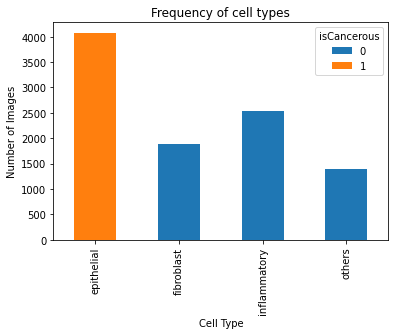

In [20]:
pd.crosstab(main_data['cellTypeName'], main_data['isCancerous'], margins = False).plot.bar(stacked = True,
                                                                                            title = 'Frequency of cell types',
                                                                                            xlabel = 'Cell Type',
                                                                                            ylabel = 'Number of Images')

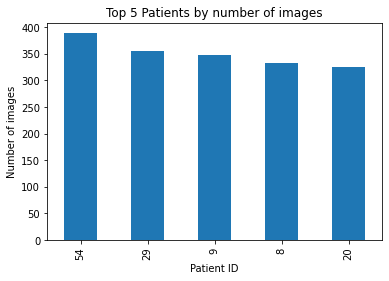

In [21]:
main_data.patientID.value_counts().nlargest(5).to_frame().plot(kind = 'bar', title = 'Top 5 Patients by number of images',
                                                               xlabel = 'Patient ID', ylabel = 'Number of images', legend = False,
                                                               label = True)

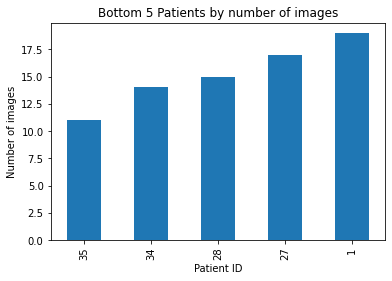

In [22]:
main_data.patientID.value_counts().nsmallest(5).to_frame().plot(kind = 'bar', title = 'Bottom 5 Patients by number of images',
                                                                xlabel = 'Patient ID', ylabel = 'Number of images', legend = False)

#### Splitting the main dataset into train, validation and test sets

In [23]:
main_train_set, main_validation_set, main_test_set = train_val_test_split_by_column(main_data, 'patientID')

In [24]:
print('Overall ferquency of isCancerous:')
print(main_data.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in training data: ')
print(main_train_set.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in validation data: ')
print(main_validation_set.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in test data: ')
print(main_test_set.isCancerous.value_counts().to_frame())

Overall ferquency of isCancerous:
   isCancerous
0         5817
1         4079
Frequency of isCancerous in training data: 
   isCancerous
0         3765
1         2882
Frequency of isCancerous in validation data: 
   isCancerous
0         1030
1          663
Frequency of isCancerous in test data: 
   isCancerous
0         1022
1          534


In [ ]:
# Graph the results
plt.figure(figsize=(3,3))
col = "cellTypeName"
hist_plot(col, [main_train_set[col], main_validation_set[col], main_test_set[col]], ['r', 'g', 'b'], 1, 1, 1)

## Examining the extra data set

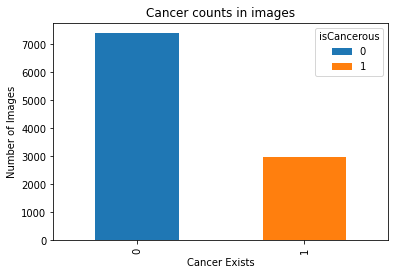

In [25]:
pd.crosstab(extra_data['isCancerous'], extra_data['isCancerous'], margins = False).plot.bar(stacked = True,
                                                                                            title = 'Cancer counts in images',
                                                                                            xlabel = 'Cancer Exists',
                                                                                            ylabel = 'Number of Images')

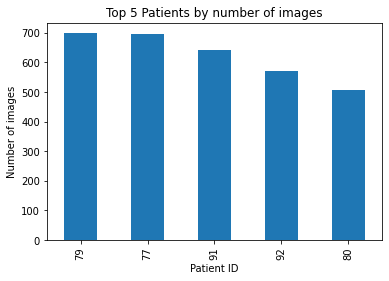

In [26]:
extra_data.patientID.value_counts().nlargest(5).to_frame().plot(kind = 'bar', title = 'Top 5 Patients by number of images',
                                                               xlabel = 'Patient ID', ylabel = 'Number of images', legend = False,
                                                               label = True)

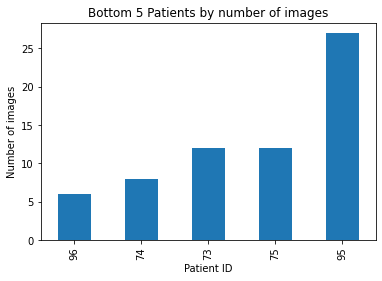

In [27]:
extra_data.patientID.value_counts().nsmallest(5).to_frame().plot(kind = 'bar', title = 'Bottom 5 Patients by number of images',
                                                                xlabel = 'Patient ID', ylabel = 'Number of images', legend = False)

#### Splitting the extra dataset into train, validation and test sets

In [28]:
extra_train_set, extra_validation_set, extra_test_set = train_val_test_split_by_column(extra_data, 'patientID')

In [29]:
print('Overall ferquency of isCancerous:')
print(extra_data.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in training data: ')
print(extra_train_set.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in validation data: ')
print(extra_validation_set.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in test data: ')
print(extra_test_set.isCancerous.value_counts().to_frame())

Overall ferquency of isCancerous:
   isCancerous
0         7394
1         2990
Frequency of isCancerous in training data: 
   isCancerous
0         4883
1         1607
Frequency of isCancerous in validation data: 
   isCancerous
1          775
0          579
Frequency of isCancerous in test data: 
   isCancerous
0         1932
1          608


In [ ]:
# # Graph the results
# plt.figure(figsize=(3,3))
# col = "cellTypeName"
# hist_plot(col, [extra_train_set[col], main_validation_set[col], main_test_set[col]], ['r', 'g', 'b'], 1, 1, 1)

### Data Setup
ImageName, InstanceID, features are excluded because they won't help in EDA since they are all unique values and are not information that is useful by themselves.

The raw data frame will be used to get the image names to map them to the images for the feature gathering.

In [30]:
# Construct non-target and target datasets. Y is target labels, X is non-target.
df_main_features = main_data.drop(['InstanceID', 'isCancerous'], axis=1)
df_main_target_label = main_data['isCancerous']

In [31]:
# Construct non-target and target datasets. Y is target labels, X is non-target.
df_extra_features = extra_data.drop(['InstanceID', 'isCancerous'], axis=1)
df_extra_target_label = extra_data['isCancerous']

In [34]:
print("Train data : {}, Val Data: {}, Test Data: {}".format(main_train_set.shape[0], main_validation_set.shape[0], main_test_set.shape[0]))

Train data : 6647, Val Data: 1693, Test Data: 1556


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

# TODO haven't figured out how to get the image path yet
train_generator = train_datagen.flow_from_dataframe(
        dataframe=hv_train_X,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="Class",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_df_main.flow_from_dataframe(
        dataframe=hv_val_X,
        directory='./',
        x_col="ImageName",
        y_col="Class",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

# Modelling 
Save the models!


In [ ]:
# CNN
# model_VGG_3 = tf.keras.Sequential([
#     #VGG block 1
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(32, 32, 3)),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#     #VGG block 2
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#     #VGG block 3
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
    
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.Dense(OUTPUT_CLASSES),
# ])

# Save model
# model_VGG_3.save("model_VGG_3")

Simple Neural Network Deep Learning - Luke Mason

Deep Learning HOG CV - Shekhar

CNN

Investigate Other Techniques hopefully OP

Explore how the data in both tasks can be used to improve the cell-type classification